<a href="https://colab.research.google.com/github/NREL/BEEAM/blob/flexlab-develop/FMU/flexlab_demo/openstudio/notebooks/ScheduleFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

Notebook for creating EnergyPlus `Schedule:File` CSV files from CSV data. 

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import libraries
import os
import pandas as pd

## 1 Setup

In [ ]:
# dirs paths
dir = r'/content/drive/Shared drives/NREL DC Design Tool/Tasks/7 Validation/7.2 Whole Tool Validation/FLEXLAB/'
in_dir = dir + r'FL_Data/Transformed'
out_dir = dir + r'NREL OpenStudio Model/2 ScheduleFiles'
elec_path = os.path.join(in_dir, 'data_FL_elec_15min.csv')
mech_temp_path = os.path.join(in_dir, 'mech_temp_3a.csv')
# print(csv_path)

# energyplus timestep per hour, must be divisible into 60
timesteps_per_hour = 4
timestep_minutes = 60 // timesteps_per_hour

# pandas frequency for date range series, used for dataframe index
frequency = str(timestep_minutes) + 'min'

# timestamp column
idx_col_name = 'datetime'

In [ ]:
# series of timestamps for dataframe index
# EnergyPlus Schedule:File requires a full year.
# https://bigladdersoftware.com/epx/docs/9-4/input-output-reference/group-schedules.html#schedulefile

date_time_index = pd.date_range(start='1/1/2020 00:00', end='12/31/2020 23:59', freq=frequency)
date_time_series = pd.Series(data=date_time_index, index=None, name=idx_col_name)
date_time_series

0       2020-01-01 00:00:00
1       2020-01-01 00:15:00
2       2020-01-01 00:30:00
3       2020-01-01 00:45:00
4       2020-01-01 01:00:00
                ...        
35131   2020-12-31 22:45:00
35132   2020-12-31 23:00:00
35133   2020-12-31 23:15:00
35134   2020-12-31 23:30:00
35135   2020-12-31 23:45:00
Name: datetime, Length: 35136, dtype: datetime64[ns]

In [ ]:
# create blank schedule file dataframe
schedule_file_df = pd.DataFrame(data=date_time_series, index=None)
schedule_file_df

,datetime
0,2020-01-01 00:00:00
1,2020-01-01 00:15:00
2,2020-01-01 00:30:00
3,2020-01-01 00:45:00
4,2020-01-01 01:00:00
...,...
35131,2020-12-31 22:45:00
35132,2020-12-31 23:00:00
35133,2020-12-31 23:15:00
35134,2020-12-31 23:30:00


In [ ]:
# check rows (2020 was a leap year)
print((365*24*timesteps_per_hour) + (24*timesteps_per_hour))

35136


# 2 Extract

In [ ]:
# read csv to data frame
elec_df = pd.read_csv(elec_path)
elec_df.describe()

,datetime,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm
0,2020-10-30 00:00:00,0.204444,0.0,94.422142,0,79.670357,0,192.213695,0.000000e+00
1,2020-10-30 00:15:00,0.204139,0.0,96.747868,0,79.862122,0,191.986834,0.000000e+00
2,2020-10-30 00:30:00,0.204015,0.0,94.834101,0,79.392693,0,191.853262,8.890000e-06
3,2020-10-30 00:45:00,0.203729,0.0,94.245913,0,79.360358,0,191.604688,0.000000e+00
4,2020-10-30 01:00:00,0.204050,0.0,96.294606,0,79.619058,0,191.750179,3.827778e-07
...,...,...,...,...,...,...,...,...,...
3067,2020-11-30 22:45:00,0.000000,0.0,0.000000,0,8.225446,0,0.091621,0.000000e+00
3068,2020-11-30 23:00:00,0.000000,0.0,0.000000,0,8.288269,0,0.091812,9.124444e-06
3069,2020-11-30 23:15:00,0.000000,0.0,0.000000,0,8.217951,0,0.092052,0.000000e+00
3070,2020-11-30 23:30:00,0.000000,0.0,0.000000,0,8.204435,0,0.092067,0.000000e+00


In [ ]:
# 3A temperatures
mech_temp_df = pd.read_csv(mech_temp_path)
mech_temp_df.describe()

,datetime,3A-IDBTS-1,3A-IDBTS-2,ave_temp
0,2020-10-30 00:00:00,17.987973,17.783198,17.885585
1,2020-10-30 00:15:00,17.672336,17.443744,17.558040
2,2020-10-30 00:30:00,17.998151,17.736743,17.867447
3,2020-10-30 00:45:00,18.693951,18.435639,18.564795
4,2020-10-30 01:00:00,19.305707,19.077607,19.191657
...,...,...,...,...
3003,2020-11-30 06:45:00,19.791396,19.766906,19.779151
3004,2020-11-30 07:00:00,19.780347,19.754736,19.767541
3005,2020-11-30 07:15:00,19.767560,19.744975,19.756268
3006,2020-11-30 07:30:00,19.754728,19.731723,19.743225


# 3 Transform

## 3.1 Electrical

In [ ]:
# convert 'time' column to datetime format
elec_df['datetime'] = pd.to_datetime(elec_df['datetime']) #, infer_datetime_format=True) 

# set index to 'time' column if data has same timestamps
# if has_same_timestamps == True:
# csv_df.set_index('datetime', inplace=True)

# show
elec_df

,datetime,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm
0,2020-10-30 00:00:00,0.204444,0.0,94.422142,0,79.670357,0,192.213695,0.000000e+00
1,2020-10-30 00:15:00,0.204139,0.0,96.747868,0,79.862122,0,191.986834,0.000000e+00
2,2020-10-30 00:30:00,0.204015,0.0,94.834101,0,79.392693,0,191.853262,8.890000e-06
3,2020-10-30 00:45:00,0.203729,0.0,94.245913,0,79.360358,0,191.604688,0.000000e+00
4,2020-10-30 01:00:00,0.204050,0.0,96.294606,0,79.619058,0,191.750179,3.827778e-07
...,...,...,...,...,...,...,...,...,...
3067,2020-11-30 22:45:00,0.000000,0.0,0.000000,0,8.225446,0,0.091621,0.000000e+00
3068,2020-11-30 23:00:00,0.000000,0.0,0.000000,0,8.288269,0,0.091812,9.124444e-06
3069,2020-11-30 23:15:00,0.000000,0.0,0.000000,0,8.217951,0,0.092052,0.000000e+00
3070,2020-11-30 23:30:00,0.000000,0.0,0.000000,0,8.204435,0,0.092067,0.000000e+00


In [ ]:
# add columns for percent of peak for fractional schedule
for col in elec_df.columns:
    if col == 'datetime':
        next
    else:
        elec_df['%s_pct' % (col)] = elec_df[col] / elec_df[col].max()

elec_df

,datetime,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm,lights_zone_pct,lights_plnm_pct,plugs_zone_pct,plugs_zone_converters_pct,misc_zone_pct,dc_hub_pct,fans_zone_pct,fans_plnm_pct
0,2020-10-30 00:00:00,0.204444,0.0,94.422142,0,79.670357,0,192.213695,0.000000e+00,0.000586,NaN,0.069942,NaN,0.418629,NaN,0.767245,0.000000e+00
1,2020-10-30 00:15:00,0.204139,0.0,96.747868,0,79.862122,0,191.986834,0.000000e+00,0.000585,NaN,0.071665,NaN,0.419637,NaN,0.766340,0.000000e+00
2,2020-10-30 00:30:00,0.204015,0.0,94.834101,0,79.392693,0,191.853262,8.890000e-06,0.000585,NaN,0.070247,NaN,0.417170,NaN,0.765806,2.860553e-08
3,2020-10-30 00:45:00,0.203729,0.0,94.245913,0,79.360358,0,191.604688,0.000000e+00,0.000584,NaN,0.069812,NaN,0.417001,NaN,0.764814,0.000000e+00
4,2020-10-30 01:00:00,0.204050,0.0,96.294606,0,79.619058,0,191.750179,3.827778e-07,0.000585,NaN,0.071329,NaN,0.418360,NaN,0.765395,1.231672e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,2020-11-30 22:45:00,0.000000,0.0,0.000000,0,8.225446,0,0.091621,0.000000e+00,0.000000,NaN,0.000000,NaN,0.043221,NaN,0.000366,0.000000e+00
3068,2020-11-30 23:00:00,0.000000,0.0,0.000000,0,8.288269,0,0.091812,9.124444e-06,0.000000,NaN,0.000000,NaN,0.043551,NaN,0.000366,2.935990e-08
3069,2020-11-30 23:15:00,0.000000,0.0,0.000000,0,8.217951,0,0.092052,0.000000e+00,0.000000,NaN,0.000000,NaN,0.043181,NaN,0.000367,0.000000e+00
3070,2020-11-30 23:30:00,0.000000,0.0,0.000000,0,8.204435,0,0.092067,0.000000e+00,0.000000,NaN,0.000000,NaN,0.043110,NaN,0.000367,0.000000e+00


In [ ]:
elec_df.describe()

,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm,lights_zone_pct,lights_plnm_pct,plugs_zone_pct,plugs_zone_converters_pct,misc_zone_pct,dc_hub_pct,fans_zone_pct,fans_plnm_pct
count,3072.000000,3072.0,3072.000000,3072.0,3072.000000,3072.0,2896.000000,2898.000000,3072.000000,0.0,3072.000000,0.0,3072.000000,0.0,2896.000000,2.898000e+03
mean,138.575425,0.0,470.560662,0.0,103.263621,0.0,181.257333,40.771685,0.397410,NaN,0.348563,NaN,0.542601,NaN,0.723511,1.311918e-01
std,115.774462,0.0,331.870223,0.0,52.163133,0.0,42.524011,31.410222,0.332021,NaN,0.245830,NaN,0.274092,NaN,0.169740,1.010693e-01
min,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.077242,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000308,0.000000e+00
25%,0.206513,0.0,359.257000,0.0,66.624120,0.0,190.125958,0.000019,0.000592,NaN,0.266116,NaN,0.350078,NaN,0.758912,6.258107e-08
50%,186.003000,0.0,452.228522,0.0,81.600032,0.0,191.504828,64.223603,0.533424,NaN,0.334984,NaN,0.428769,NaN,0.764416,2.066535e-01
75%,186.003000,0.0,541.686000,0.0,165.049790,0.0,192.458835,64.492056,0.533424,NaN,0.401249,NaN,0.867257,NaN,0.768224,2.075173e-01
max,348.696062,0.0,1350.000000,0.0,190.312339,0.0,250.524505,310.779113,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,1.000000e+00


In [ ]:
# add columns to schedule file dataframe
elec_schedule_file_df = pd.merge_ordered(schedule_file_df, elec_df, on='datetime')
elec_schedule_file_df

,datetime,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm,lights_zone_pct,lights_plnm_pct,plugs_zone_pct,plugs_zone_converters_pct,misc_zone_pct,dc_hub_pct,fans_zone_pct,fans_plnm_pct
0,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,2020-12-31 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35132,2020-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35133,2020-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35134,2020-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
elec_schedule_file_df.describe()

,lights_zone,lights_plnm,plugs_zone,plugs_zone_converters,misc_zone,dc_hub,fans_zone,fans_plnm,lights_zone_pct,lights_plnm_pct,plugs_zone_pct,plugs_zone_converters_pct,misc_zone_pct,dc_hub_pct,fans_zone_pct,fans_plnm_pct
count,3072.000000,3072.0,3072.000000,3072.0,3072.000000,3072.0,2896.000000,2898.000000,3072.000000,0.0,3072.000000,0.0,3072.000000,0.0,2896.000000,2.898000e+03
mean,138.575425,0.0,470.560662,0.0,103.263621,0.0,181.257333,40.771685,0.397410,NaN,0.348563,NaN,0.542601,NaN,0.723511,1.311918e-01
std,115.774462,0.0,331.870223,0.0,52.163133,0.0,42.524011,31.410222,0.332021,NaN,0.245830,NaN,0.274092,NaN,0.169740,1.010693e-01
min,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.077242,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000308,0.000000e+00
25%,0.206513,0.0,359.257000,0.0,66.624120,0.0,190.125958,0.000019,0.000592,NaN,0.266116,NaN,0.350078,NaN,0.758912,6.258107e-08
50%,186.003000,0.0,452.228522,0.0,81.600032,0.0,191.504828,64.223603,0.533424,NaN,0.334984,NaN,0.428769,NaN,0.764416,2.066535e-01
75%,186.003000,0.0,541.686000,0.0,165.049790,0.0,192.458835,64.492056,0.533424,NaN,0.401249,NaN,0.867257,NaN,0.768224,2.075173e-01
max,348.696062,0.0,1350.000000,0.0,190.312339,0.0,250.524505,310.779113,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,1.000000e+00


## 3.2 Mechanical

In [ ]:
# change format of timestamp for merging
# mech_temp_df[idx_col_name] = pd.to_datetime(mech_temp_df[idx_col_name])

# 
mech_temp_schedule_file_df = pd.merge_ordered(schedule_file_df, mech_temp_df, on=idx_col_name)
mech_temp_schedule_file_df

,datetime,3A-IDBTS-1,3A-IDBTS-2,ave_temp
0,2020-01-01 00:00:00,NaN,NaN,NaN
1,2020-01-01 00:15:00,NaN,NaN,NaN
2,2020-01-01 00:30:00,NaN,NaN,NaN
3,2020-01-01 00:45:00,NaN,NaN,NaN
4,2020-01-01 01:00:00,NaN,NaN,NaN
...,...,...,...,...
35131,2020-12-31 22:45:00,NaN,NaN,NaN
35132,2020-12-31 23:00:00,NaN,NaN,NaN
35133,2020-12-31 23:15:00,NaN,NaN,NaN
35134,2020-12-31 23:30:00,NaN,NaN,NaN


In [ ]:
# drop columns
mech_temp_schedule_file_df.drop(['3A-IDBTS-1', '3A-IDBTS-2'], axis=1, inplace=True)

# replace NaN with 100C for cooling setpoint
mech_temp_schedule_file_df['ave_temp'].fillna(value=100, inplace=True)
mech_temp_schedule_file_df

,datetime,ave_temp
0,2020-01-01 00:00:00,100.0
1,2020-01-01 00:15:00,100.0
2,2020-01-01 00:30:00,100.0
3,2020-01-01 00:45:00,100.0
4,2020-01-01 01:00:00,100.0
...,...,...
35131,2020-12-31 22:45:00,100.0
35132,2020-12-31 23:00:00,100.0
35133,2020-12-31 23:15:00,100.0
35134,2020-12-31 23:30:00,100.0


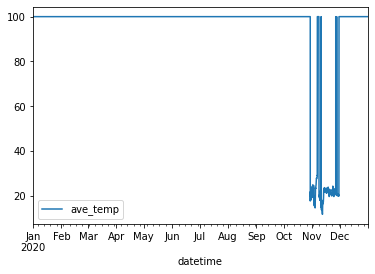

In [ ]:
mech_temp_schedule_file_df.set_index(idx_col_name).plot()

# 4 Load

In [ ]:
# save dataframe to csv
# schedule_file_path = os.path.join(out_dir, 'schedulefile_' + name)
# schedule_file_df.to_csv(schedule_file_path, index=False)
mech_temp_schedule_file_df.to_csv(os.path.join(out_dir, 'schedulefile_mech_15min.csv'), index=False)

# Scratch